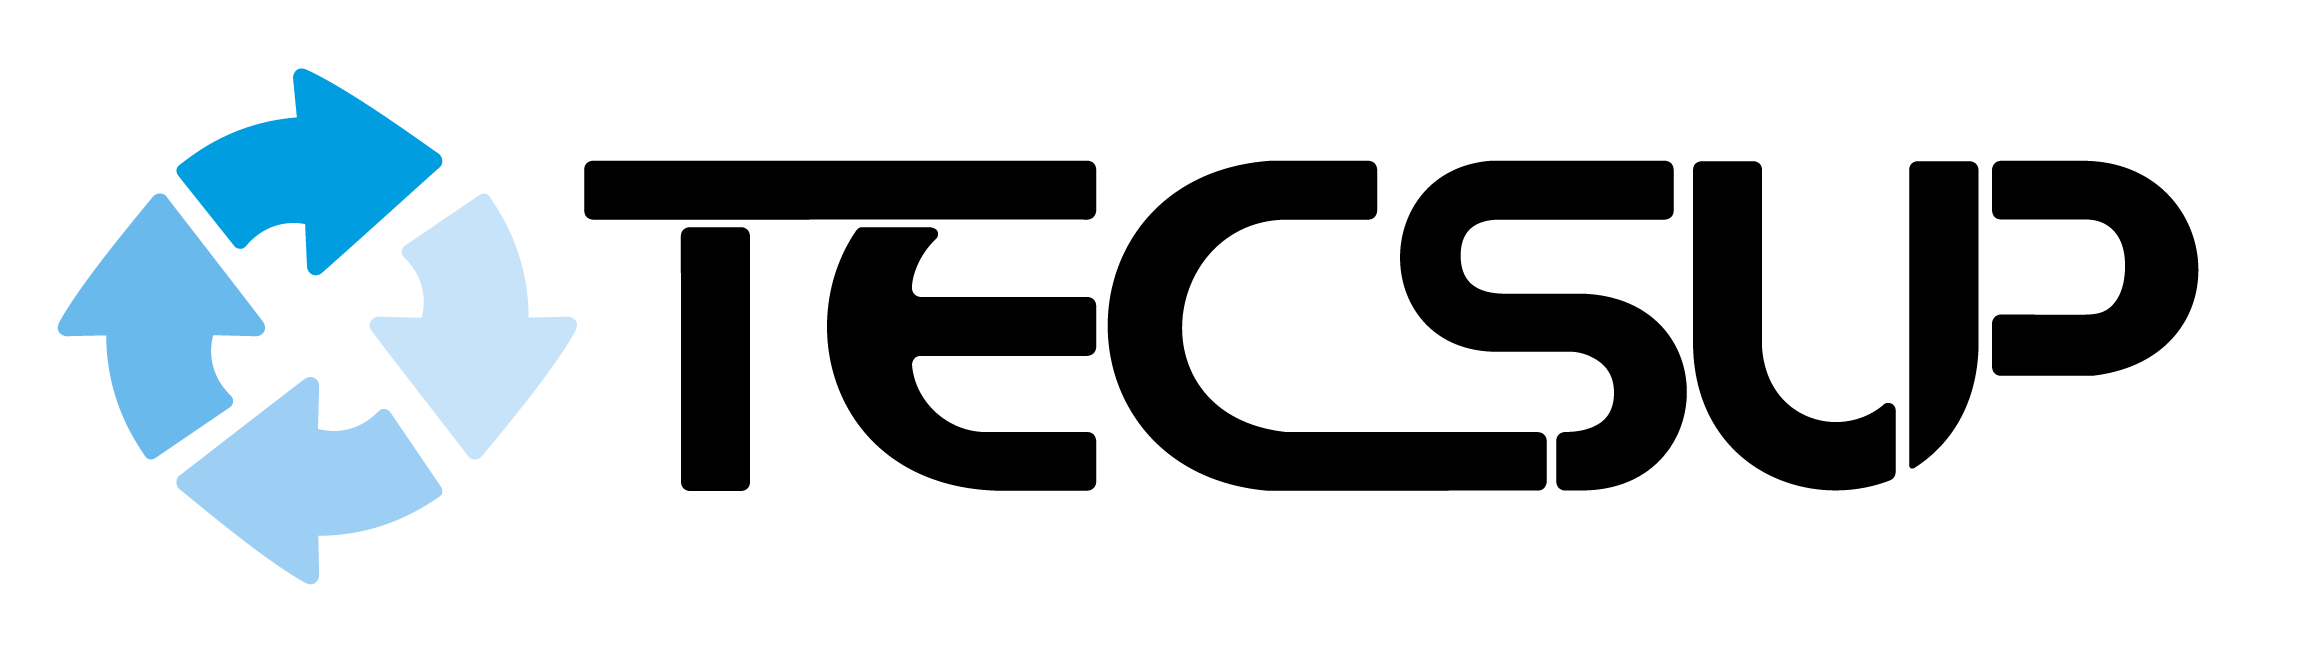

# LABORATORIO 11
# NOMBRE: ARCOS ANSELMO FRANK FERNANDO RODOLFO

### A) Realice el preprocesamiento de la información que incluya el análisis de datos faltantes, tratamiento de outliers a nivel univariado y multivariado y escalamiento de datos para las variables numéricas.

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv('/content/drive/MyDrive/BIG DATA Y CIENCIAS DE DATOS/MINERIA DE DATOS/Advertising.csv' , delimiter=';')

# Análisis de datos faltantes
print("Datos faltantes por columna:")
print(df.isnull().sum())

# Tratamiento de outliers univariados (z-score)
from scipy.stats import zscore
z_scores = np.abs(zscore(df.select_dtypes(include=np.number)))
df_no_outliers_uni = df[(z_scores < 3).all(axis=1)]

# Tratamiento de outliers multivariado (Distancia de Mahalanobis)
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

X_num = df_no_outliers_uni.select_dtypes(include=np.number)
mean_vec = X_num.mean().values
cov_matrix = np.cov(X_num.values.T)
inv_cov_matrix = inv(cov_matrix)

def mahalanobis_distance(x):
    return mahalanobis(x, mean_vec, inv_cov_matrix)

df_no_outliers_uni['mahal'] = X_num.apply(mahalanobis_distance, axis=1)
threshold = np.percentile(df_no_outliers_uni['mahal'], 97.5)
df_final = df_no_outliers_uni[df_no_outliers_uni['mahal'] < threshold].drop(columns='mahal')



Datos faltantes por columna:
TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64


<ipython-input-7-985f2f6fbd24>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers_uni['mahal'] = X_num.apply(mahalanobis_distance, axis=1)


In [9]:
target_column = 'Sales'


In [10]:
# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final.drop(columns=target_column))
X_scaled = pd.DataFrame(X_scaled, columns=df_final.drop(columns=target_column).columns)

# Variables finales
X = X_scaled.reset_index(drop=True)
y = df_final[target_column].reset_index(drop=True)

In [3]:
print(df.columns)


Index(['TV;Radio;Newspaper;Sales'], dtype='object')


In [11]:
print(df)

        TV  Radio  Newspaper  Sales
0    230.1   37.8       69.2   22.1
1     44.5   39.3       45.1   10.4
2     17.2   45.9       69.3    9.3
3    151.5   41.3       58.5   18.5
4    180.8   10.8       58.4   12.9
..     ...    ...        ...    ...
195   38.2    3.7       13.8    7.6
196   94.2    4.9        8.1    9.7
197  177.0    9.3        6.4   12.8
198  283.6   42.0       66.2   25.5
199  232.1    8.6        8.7   13.4

[200 rows x 4 columns]


### Cree un algoritmo genético para seleccionar las mejores variables para un modelo de regresión lineal incluyendo diversos valores para los parámetros: tamaño de la población, probabilidad de cruce, probabilidad de mutación y número de generaciones

In [16]:
from deap import base, creator, tools, algorithms
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [17]:
# Configuración del algoritmo genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximizar R2
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
n_features = X.shape[1]
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [18]:
# Función de evaluación
def evalModel(individual):
    if sum(individual) == 0:
        return 0,
    selected = [i for i, bit in enumerate(individual) if bit == 1]
    X_sel = X.iloc[:, selected]
    model = LinearRegression()
    r2 = cross_val_score(model, X_sel, y, cv=5, scoring='r2').mean()
    return r2,

toolbox.register("evaluate", evalModel)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


In [19]:
# Parámetros
population = toolbox.population(n=30)
NGEN = 40
CXPB = 0.7
MUTPB = 0.2

# Evolución
r2_evolution = []

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = list(map(toolbox.evaluate, offspring))

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))
    top = tools.selBest(population, k=1)[0]
    r2_evolution.append(top.fitness.values[0])

In [20]:
# Mejores variables
best_individual = tools.selBest(population, k=1)[0]
best_vars = [X.columns[i] for i, bit in enumerate(best_individual) if bit == 1]
print("Mejores variables:", best_vars)

Mejores variables: ['TV', 'Radio']


### Realice un gráfico de la evolución del coeficiente de determinación (R2), seleccione las mejores variables, cree un modelo de regresión lineal con base a estas tomando un 80% de datos para el entrenamiento y mida su desempeño con el R2.

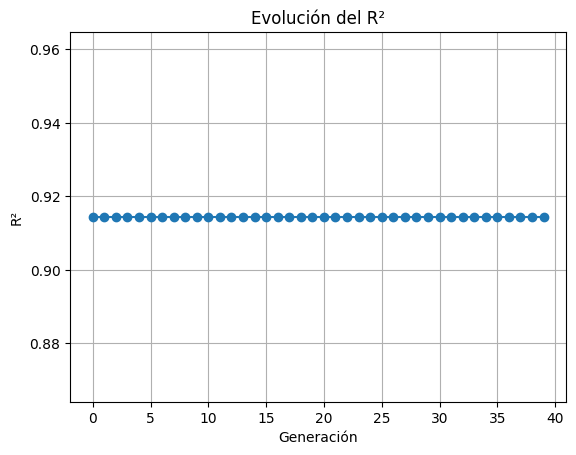

R² del modelo final: 0.8501


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Gráfico evolución R²
plt.plot(range(NGEN), r2_evolution, marker='o')
plt.title('Evolución del R²')
plt.xlabel('Generación')
plt.ylabel('R²')
plt.grid(True)
plt.show()

# Datos finales para modelo
X_selected = X[best_vars]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Modelo
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluación
r2_final = r2_score(y_test, y_pred)
print(f"R² del modelo final: {r2_final:.4f}")
